<a href="https://colab.research.google.com/github/Mpr9640/Transfer-Learning/blob/main/its_me_TransLearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load the full dataset
(full_x_train, full_y_train), (full_x_test, full_y_test) = fashion_mnist.load_data()

# Normalize the pixel values
full_x_train, full_x_test = full_x_train / 255.0, full_x_test / 255.0

In [ ]:
# Expand dimensions to include channel information
full_x_train = np.expand_dims(full_x_train, -1)
full_x_test = np.expand_dims(full_x_test, -1)

In [ ]:
#data agumentation
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

In [ ]:
#only 5 classes out of 10
n1 = 5        # We will use all the examples of these n1 classes: base task is to learn the base model

base_classes = range(n1)
idx_train = np.isin(full_y_train, base_classes)
idx_test = np.isin(full_y_test, base_classes)

base_x_train, base_y_train = full_x_train[idx_train], full_y_train[idx_train]
base_x_test, base_y_test = full_x_test[idx_test], full_y_test[idx_test]

# Convert labels to one-hot encoding
base_y_train = to_categorical(base_y_train, num_classes=n1)
base_y_test = to_categorical(base_y_test, num_classes=n1)


In [ ]:
from tensorflow.keras import layers, models

input_shape = (28, 28, 1)

model = models.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),    #What we see on lines 11 and 12 is an MLP that uses the features conv-layers extracted
    layers.Dense(n1, activation='softmax')
])

In [ ]:
#freezing all layers by leaving last three layers
for layer in model.layers[:-3]:
    layer.trainable = False

In [ ]:
#adding new layers
model.layers.extend(model.layers[:-3])
model.add(layers.Flatten())  # Flatten for dense layers
model.add(layers.Dense(64, activation='relu'))  # Add a new dense layer
model.add(layers.Dense(5, activation='softmax'))

In [ ]:
num_samples_per_class = 10                # each label with 10 examples and getting the data from base classes
n2=10-n1
target_classes = range(n1, 10)
idx_train = np.isin(full_y_train, target_classes)
idx_test = np.isin(full_y_test, target_classes)

target_x_train, target_y_train = full_x_train[idx_train], full_y_train[idx_train]

all_selected_indices = []
for class_label in target_classes:
    # Indices of all instances of the current class
    class_indices = np.where(target_y_train == class_label)[0]

    # Randomly choose num_samples_per_class indices from this class
    chosen_indices = np.random.choice(class_indices, num_samples_per_class, replace=False)

    # Append these indices to the list
    all_selected_indices.extend(chosen_indices)  # Use extend or +

# Use the selected indices to build the small dataset for the target task
target_x_train, target_y_train = target_x_train[all_selected_indices], target_y_train[all_selected_indices]

target_x_test, target_y_test = full_x_test[idx_test], full_y_test[idx_test]

# Convert labels to one-hot encoding
target_y_train = to_categorical(target_y_train - n1, num_classes=n2)
target_y_test = to_categorical(target_y_test - n1, num_classes=n2)
# For binary (class 8 vs 9), we could also use:
#target_y_train = 0+(target_y_train == 8)   #also works: (target_y_train == 8).astype(int)

target_y_train.shape

(50, 5)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping to monitor overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
#train and get the valid accuracy
history=model.fit(datagen.flow(target_x_train, target_y_train), epochs=50, validation_data=(target_x_test,target_y_test),callbacks=[early_stopping])


Epoch 1/50
2/2 [==============================] - 3s 3s/step - loss: 1.0824 - accuracy: 0.5800 - val_loss: 1.1009 - val_accuracy: 0.5860
Epoch 2/50
2/2 [==============================] - 2s 2s/step - loss: 1.0906 - accuracy: 0.6400 - val_loss: 1.0951 - val_accuracy: 0.5870
Epoch 3/50
2/2 [==============================] - 3s 3s/step - loss: 1.0472 - accuracy: 0.6400 - val_loss: 1.0914 - val_accuracy: 0.5860
Epoch 4/50
2/2 [==============================] - 3s 3s/step - loss: 1.0641 - accuracy: 0.6000 - val_loss: 1.0872 - val_accuracy: 0.5796
Epoch 5/50
2/2 [==============================] - 1s 1s/step - loss: 1.0546 - accuracy: 0.6400 - val_loss: 1.0773 - val_accuracy: 0.5922
Epoch 6/50
2/2 [==============================] - 3s 3s/step - loss: 1.0616 - accuracy: 0.6400 - val_loss: 1.0671 - val_accuracy: 0.6042
Epoch 7/50
2/2 [==============================] - 3s 3s/step - loss: 1.0706 - accuracy: 0.5800 - val_loss: 1.0597 - val_accuracy: 0.6030
Epoch 8/50
2/2 [=========================

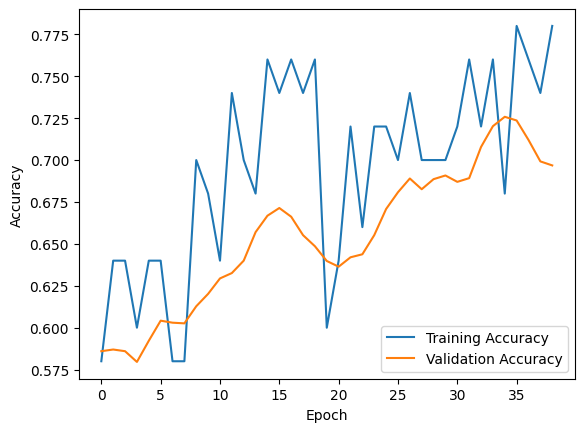

In [ ]:
# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# Train the model
history=model.fit(datagen.flow(base_x_train, base_y_train), epochs=5, validation_data=(base_x_test,base_y_test))

# Evaluate the new model on the test set
print('\nNot the focus of transfer learning, but a good accuracy here shows learned base features can be good:')
test_loss, test_acc = model.evaluate(base_x_test, base_y_test)
print(f"Base-task test loss: {test_loss}")
print(f"Base-task test accuracy: {test_acc}")

# Alternative to "evaluate", we can use the model to predict the classes of the test set and then calculate the accuracy
predictions = model.predict(base_x_test)
# The predictions are in the form of probabilities for each class.
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(base_y_test, axis=1)
# Calculate accuracy by comparing predicted and true classes
accuracy = np.mean(predicted_classes == true_classes)
print(f"Alternative way of computing accuracy: {accuracy}")

Epoch 1/5
938/938 [==============================] - 23s 25ms/step - loss: 0.9141 - accuracy: 0.6150 - val_loss: 0.5925 - val_accuracy: 0.7712
Epoch 2/5
938/938 [==============================] - 22s 24ms/step - loss: 0.5658 - accuracy: 0.7833 - val_loss: 0.5096 - val_accuracy: 0.7964
Epoch 3/5
938/938 [==============================] - 20s 22ms/step - loss: 0.5069 - accuracy: 0.8078 - val_loss: 0.4581 - val_accuracy: 0.8228
Epoch 4/5
938/938 [==============================] - 22s 23ms/step - loss: 0.4749 - accuracy: 0.8201 - val_loss: 0.4468 - val_accuracy: 0.8338
Epoch 5/5
938/938 [==============================] - 21s 23ms/step - loss: 0.4544 - accuracy: 0.8282 - val_loss: 0.4210 - val_accuracy: 0.8486

Not the focus of transfer learning, but a good accuracy here shows learned base features can be good:
157/157 [==============================] - 1s 9ms/step - loss: 0.4210 - accuracy: 0.8486
Base-task test loss: 0.4210260808467865
Base-task test accuracy: 0.8485999703407288
157/157 [

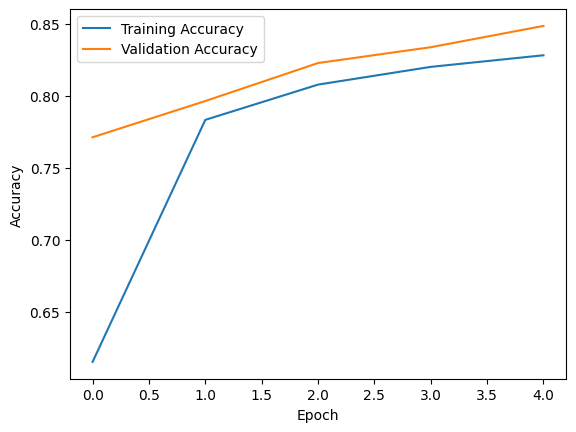

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()